# Importing the dependencies

In [38]:
# Necessary Dependencies
import numpy as np
import awkward as ak
import pandas as pd
import uproot
from datetime import datetime
import os
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Model specific dependencies
# Tensorflow
import tensorflow.keras as keras

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Pytorch
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataListLoader
from torch.utils.data import random_split
import torch.nn.functional as F

In [4]:
# metrics
from sklearn.metrics import roc_curve, auc

In [5]:
# Others
import yaml
import utilities.utils as utils
from utilities.deepset_adversarial_datagenerator import DataGenerator
from utilities.gnn_data_generator import GraphDataset
from tqdm.notebook import tqdm

# Time Log

In [6]:
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

# Importing the datasets

In [7]:
files = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_0.root']
n_sample = 5000
# n_sample = 200000*0.1

In [8]:
# For BDT
with open('utilities/definitions_bdt_dnn.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)
    file.close()
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

feature_array_bdt, label_array_bdt, spectator_array_bdt = utils.get_features_labels(files[0],
                                                                                             features = features,
                                                                                             labels = labels,
                                                                                             spectators = spectators,
                                                                                             entry_stop= n_sample)

for j in range(len(feature_array_bdt)):
    for i in range(len(feature_array_bdt[j, :])):
        if type(feature_array_bdt[j, i]) != float:
            feature_array_bdt[j, i] = feature_array_bdt[j, i].mean()

feature_array_bdt = feature_array_bdt.astype(np.float32)  # or float64

In [9]:
# For DNN
with open('utilities/definitions_bdt_dnn.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)
    file.close()
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

feature_array_dnn, label_array_dnn, spectator_array_dnn = utils.get_features_labels(files[0],
                                                                                             features = features,
                                                                                             labels = labels,
                                                                                             spectators = spectators,
                                                                                             entry_stop= n_sample)

for j in range(len(feature_array_dnn)):
    for i in range(len(feature_array_dnn[j, :])):
        if type(feature_array_dnn[j, i]) != float:
            feature_array_dnn[j, i] = feature_array_dnn[j, i].mean()

feature_array_dnn = feature_array_dnn.astype(np.float32)  # or float64

In [10]:
# For Deepset
with open('utilities/definitions_gnn_deepset_adversarial.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

test_generator_dnn_deepset = DataGenerator(files, features, labels, spectators, batch_size = 1000, remove_unlabeled=True, remove_mass_pt_window = True, return_spectators=True, n_dim = ntracks, max_entry = n_sample)

In [11]:
# For CNN
with open('utilities/definitions_cnn.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nlabels = definitions['nlabels']
nspectators = definitions['nspectators']

feature_array_cnn, label_array_cnn, spectator_array_cnn = utils.get_features_labels(files[0],
                                                                                 features,
                                                                                 spectators,
                                                                                 labels,
                                                                                 remove_mass_pt_window = True,
                                                                                 entry_stop= n_sample)

# converting feature array into image array
image_array_cnn = utils.make_image(feature_array_cnn)

In [12]:
# For Adversarial
with open('utilities/definitions_gnn_deepset_adversarial.yml') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
labels = definitions['labels']
spectators = definitions['spectators']

nfeatures = definitions['nfeatures']
nlabels = definitions['nlabels']
nspectators = definitions['nspectators']
ntracks = definitions['ntracks']

test_generator_adversarial = DataGenerator(
    files, features, labels, spectators,
    batch_size = 1024,
    n_dim = ntracks,
    remove_mass_pt_window = True,
    remove_unlabeled = True,
    return_spectators = True,
    max_entry = n_sample
)

In [13]:
# For GNN
with open('utilities/definitions_gnn_deepset_adversarial.yml') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
labels = definitions['labels']
spectators = definitions['spectators']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

test_dataset_gnn = GraphDataset(f'gdata_test_{nfeatures}_{n_sample}_1', features, labels, spectators, n_events = n_sample, n_events_merge = 1, file_names = files)

# Predicting with BDT

In [14]:
# Loading the model
import joblib

bdt_model = joblib.load('trained_models/new_models/trained_bdt_model.pkl')

# Predicting the result
label_array_bdt_predict = bdt_model.predict_proba(feature_array_bdt)

del bdt_model

# Predicting with DNN

In [15]:
# Loading the model
from keras.models import load_model

dnn_model = load_model('trained_models/new_models/keras_model_best_dnn.keras')

label_array_dnn_predict = dnn_model.predict(feature_array_dnn)

del dnn_model

2025-07-11 18:06:34.874185: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-11 18:06:34.874205: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-11 18:06:34.874209: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-11 18:06:34.874243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-11 18:06:34.874251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-07-11 18:06:35.119350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


# Predicting with deepset

In [16]:
# Loading the model
from keras.models import load_model

deepset_model = load_model('trained_models/new_models/keras_model_best_deepset.keras')

label_array_deepset_predict = []
label_array_deepset = []
spectator_array_deepset = []

for i, t in enumerate(test_generator_dnn_deepset):
    if t is None:
        break  # Stop when an empty batch is encountered
    else:
        label_array_deepset_predict.append(deepset_model.predict(t[0]))
        label_array_deepset.append(t[1][0])
        spectator_array_deepset.append(t[1][1])

# concatenating the sets
label_array_deepset_predict = np.concatenate(label_array_deepset_predict, axis = 0)
label_array_deepset = np.concatenate(label_array_deepset, axis = 0)
spectator_array_deepset = np.concatenate(spectator_array_deepset, axis = 0)

del deepset_model

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# Predicting with CNN

In [17]:
# Loading the model (Everything running in cpu
from keras.models import load_model

cnn_model = load_model('trained_models/new_models/keras_model_best_cnn.keras')

label_array_cnn_predict = cnn_model.predict(image_array_cnn)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [18]:
# os.environ.pop("CUDA_VISIBLE_DEVICES", None)  # remove the environment variable

In [19]:
# Note: Use this if gpu memory is suffecient
# import tensorflow as tf

# # Suppose your input data is a NumPy array (e.g., images)
# image_array_cnn = image_array_cnn.astype('float32')  # ensure float32

# # Convert to TensorFlow tensor
# input_tensor = tf.convert_to_tensor(image_array_cnn)

# # Explicitly move to GPU using tf.device()
# with tf.device('/GPU:0'):
#     predictions = cnn_model(input_tensor, training=False)


# Predicting with Adversarial

In [20]:
# Loading the model (Everything running in cpu
from keras.models import load_model

adversarial_model = load_model('trained_models/new_models/keras_model_best_adversarial.keras')

label_array_adversarial_predict = []
label_array_adversarial = []
spectator_array_adversarial = []

for i, t in enumerate(test_generator_adversarial):
    if t is None:
        break
    else:
        label_array_adversarial.append(t[1][0])
        spectator_array_adversarial.append(t[1][1])
        label_array_adversarial_predict.append(adversarial_model.predict(t[0])[0])

label_array_adversarial_predict = np.concatenate(label_array_adversarial_predict, axis = 0)
label_array_adversarial = np.concatenate(label_array_adversarial, axis = 0)
spectator_array_adversarial = np.concatenate(spectator_array_adversarial, axis = 0)

del adversarial_model

/Users/sashibhusansahoo/miniforge3/envs/hep/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/sashibhusansahoo/miniforge3/envs/hep/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


# Predicting with GNN

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
batch_size = 32
test_loader_gnn = DataListLoader(test_dataset_gnn, batch_size = batch_size, pin_memory = True, shuffle = False)
test_loader_gnn.collate_fn = collate

test_samples = len(test_dataset_gnn)
print(test_samples)

1599


In [22]:
# Loading the model
from in_model import InteractionNetwork

# gnn_model = InteractionNetwork().to(device)
gnn_model = InteractionNetwork()

gnn_model_path = osp.join(f'trained_models/new_models/keras_model_best_gnn_74.pth')
# gnn_model.load_state_dict(torch.load(gnn_model_path)) # Use this if GPU is available
gnn_model.load_state_dict(torch.load(gnn_model_path, map_location=torch.device('cpu')))
gnn_model.eval() # Set to evaluation mode
gnn_model.to(device)

t = tqdm(enumerate(test_loader_gnn), total= test_samples/batch_size)
label_array_gnn = []
label_array_gnn_predict = []
spectator_array_gnn = []
for i, data in t:
    data = data.to(device)
    batch_output = gnn_model(data.x, data.edge_index, data.batch)

    probs = F.softmax(batch_output, dim=1)
    
    label_array_gnn_predict.append(probs.detach().cpu().numpy())
    label_array_gnn.append(data.y.cpu().numpy())
    spectator_array_gnn.append(data.u.cpu().numpy())
label_array_gnn = np.concatenate(label_array_gnn)
label_array_gnn_predict = np.concatenate(label_array_gnn_predict)
spectator_array_gnn = np.concatenate(spectator_array_gnn)

del gnn_model

/Users/sashibhusansahoo/miniforge3/envs/hep/lib/python3.10/site-packages/torch/utils/data/dataloader.py:685: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/49.96875 [00:00<?, ?it/s]

# TPR, FPR, Threshold

In [23]:
fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(label_array_bdt[:, 1], label_array_bdt_predict[:, 1])
fpr_dnn, tpr_dnn, threshold_dnn = roc_curve(label_array_dnn[:, 1], label_array_dnn_predict[:, 1])
fpr_deepset, tpr_deepset, threshold_deepset = roc_curve(label_array_deepset[:, 1], label_array_deepset_predict[:, 1])
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(label_array_cnn[:, 1], label_array_cnn_predict[:, 1])
fpr_adversarial, tpr_adversarial, threshold_adversarial = roc_curve(label_array_adversarial[:, 1], label_array_adversarial_predict[:, 1])
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(label_array_gnn[:, 1], label_array_gnn_predict[:, 1])

# AUC

In [24]:
auc_bdt = auc(fpr_bdt, tpr_bdt)*100
auc_dnn = auc(fpr_dnn, tpr_dnn)*100
auc_deepset = auc(fpr_deepset, tpr_deepset)*100
auc_cnn = auc(fpr_cnn, tpr_cnn)*100
auc_adversarial = auc(fpr_adversarial, tpr_adversarial)*100
auc_gnn = auc(fpr_gnn, tpr_gnn)*100

# ROC Curve

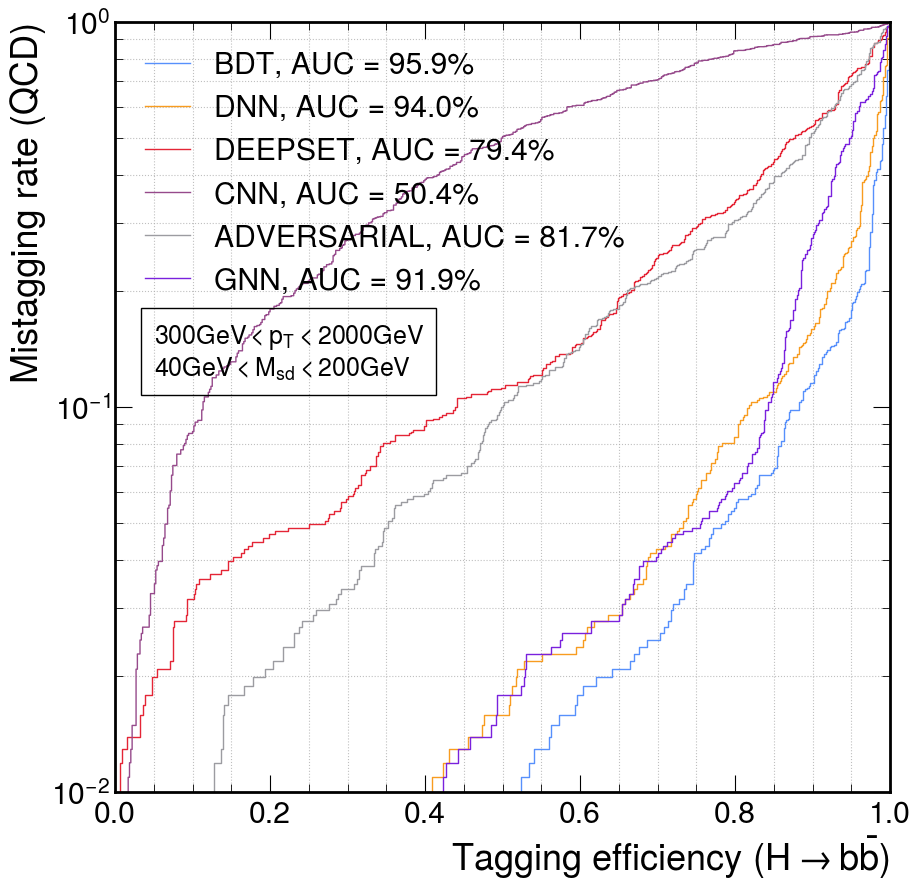

In [25]:
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ROOT)

train_samples = 18835
valid_samples = 3781
test_samples = 4679

# Plot ROC curves
plt.figure()
plt.plot(tpr_bdt, fpr_bdt, lw = 1, label = "BDT, AUC = {:.1f}%".format(auc_bdt))
plt.plot(tpr_dnn, fpr_dnn, lw = 1, label = "DNN, AUC = {:.1f}%".format(auc_dnn))
plt.plot(tpr_deepset, fpr_deepset, lw = 1, label = "DEEPSET, AUC = {:.1f}%".format(auc_deepset))
plt.plot(tpr_cnn, fpr_cnn, lw = 1, label = "CNN, AUC = {:.1f}%".format(auc_cnn))
plt.plot(tpr_adversarial, fpr_adversarial, lw = 1, label = "ADVERSARIAL, AUC = {:.1f}%".format(auc_adversarial))
plt.plot(tpr_gnn, fpr_gnn, lw = 1, label = "GNN, AUC = {:.1f}%".format(auc_gnn))
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')


# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)
plt.show()

In [26]:
# Desired FPR (1% = 0.01)
fpr = 0.01

# Interpolate to find the corresponding TPR
tpr_bdt_min = np.interp(fpr, fpr_bdt, tpr_bdt)
tpr_dnn_min = np.interp(fpr, fpr_dnn, tpr_dnn)
tpr_deepset_min = np.interp(fpr, fpr_deepset, tpr_deepset)
tpr_cnn_min = np.interp(fpr, fpr_cnn, tpr_cnn)
tpr_adversarial_min = np.interp(fpr, fpr_adversarial, tpr_adversarial)
tpr_gnn_min = np.interp(fpr, fpr_gnn, tpr_gnn)

print(f"BDT Tagging Efficency at 1% FPR: {tpr_bdt_min:.4f}")
print(f"DNN Tagging Efficency at 1% FPR: {tpr_dnn_min:.4f}")
print(f"DEEPSET Tagging Efficency at 1% FPR: {tpr_deepset_min:.4f}")
print(f"CNN Tagging Efficency at 1% FPR: {tpr_cnn_min:.4f}")
print(f"ADVERSARIAL Tagging Efficency at 1% FPR: {tpr_adversarial_min:.4f}")
print(f"GNN Tagging Efficency at 1% FPR: {tpr_gnn_min:.4f}")

BDT Tagging Efficency at 1% FPR: 0.5237
DNN Tagging Efficency at 1% FPR: 0.4085
DEEPSET Tagging Efficency at 1% FPR: 0.0068
CNN Tagging Efficency at 1% FPR: 0.0169
ADVERSARIAL Tagging Efficency at 1% FPR: 0.1271
GNN Tagging Efficency at 1% FPR: 0.4237


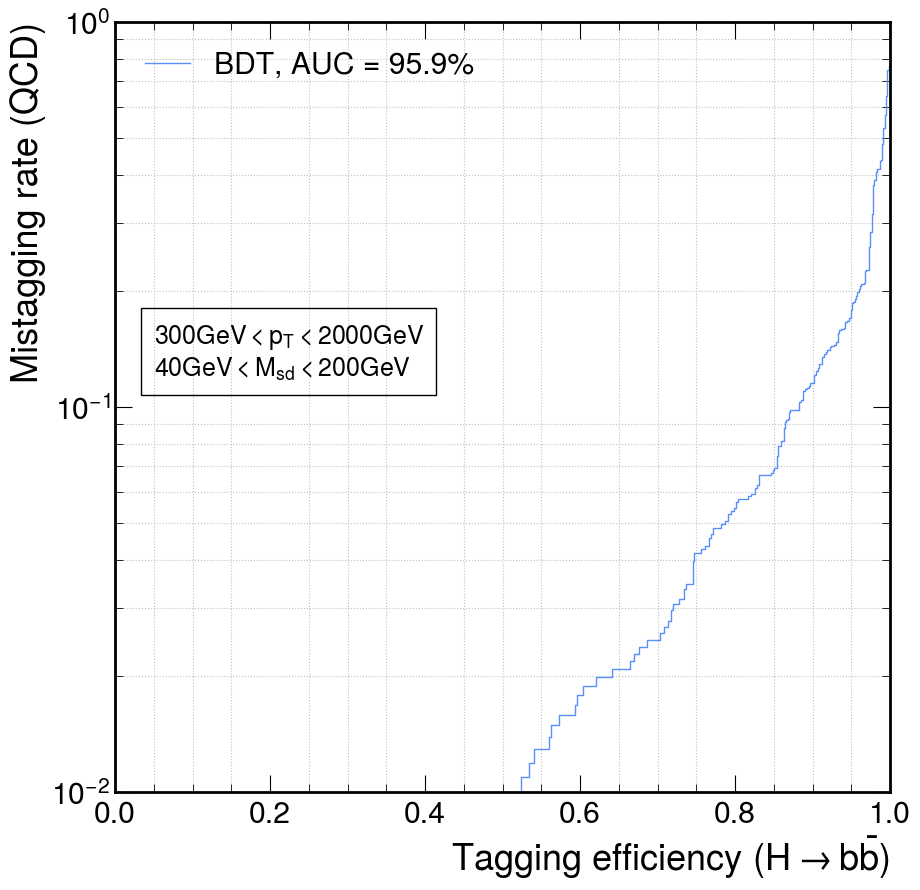

In [27]:
# Plot ROC curves
plt.figure()
plt.plot(tpr_bdt, fpr_bdt, lw = 1, label = "BDT, AUC = {:.1f}%".format(auc_bdt))
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

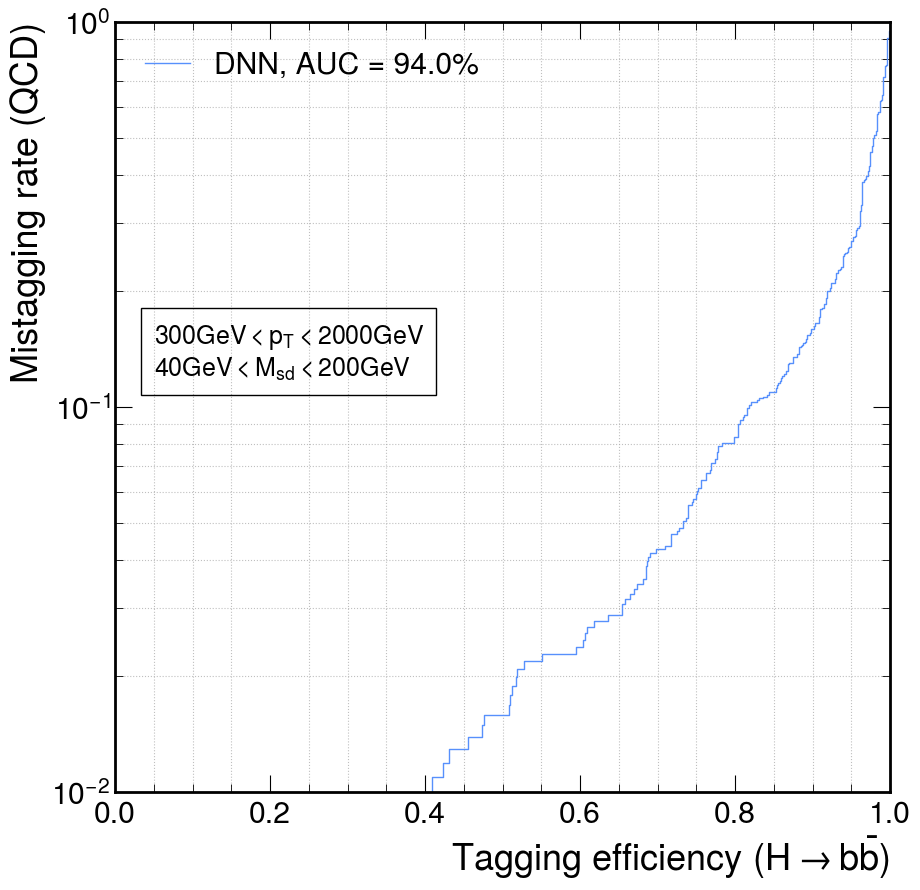

In [28]:
# Plot ROC curves
plt.figure()
plt.plot(tpr_dnn, fpr_dnn, lw = 1, label = "DNN, AUC = {:.1f}%".format(auc_dnn))

plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

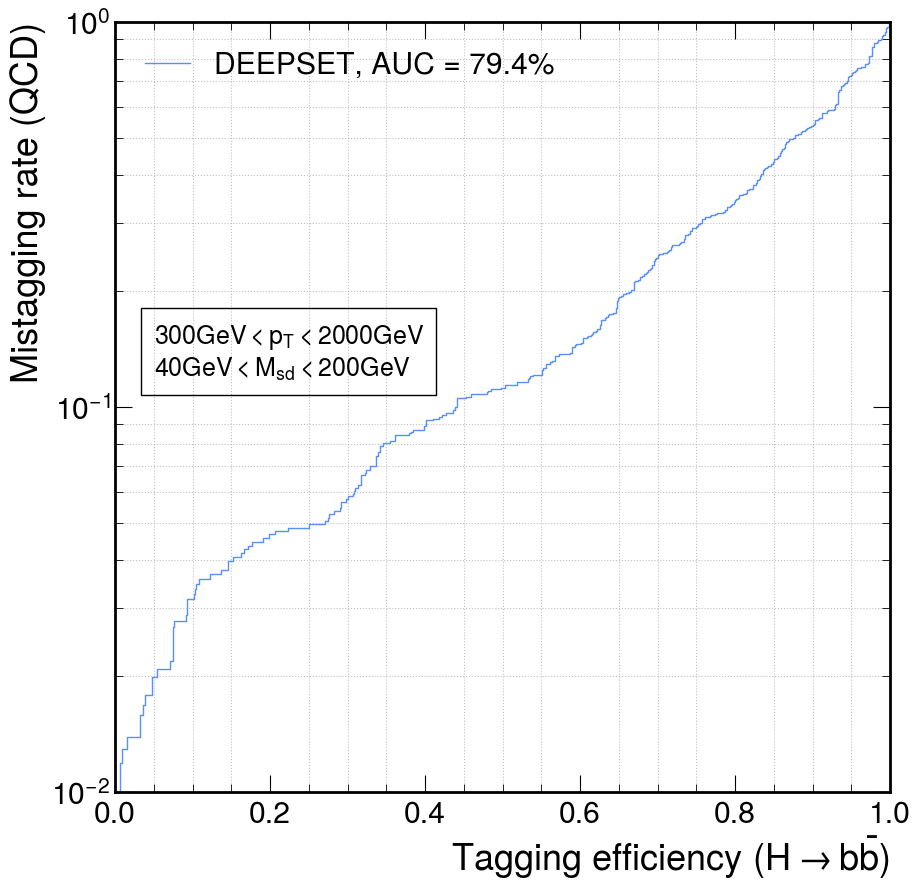

In [29]:
# Plot ROC curves
plt.figure()

plt.plot(tpr_deepset, fpr_deepset, lw = 1, label = "DEEPSET, AUC = {:.1f}%".format(auc_deepset))
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

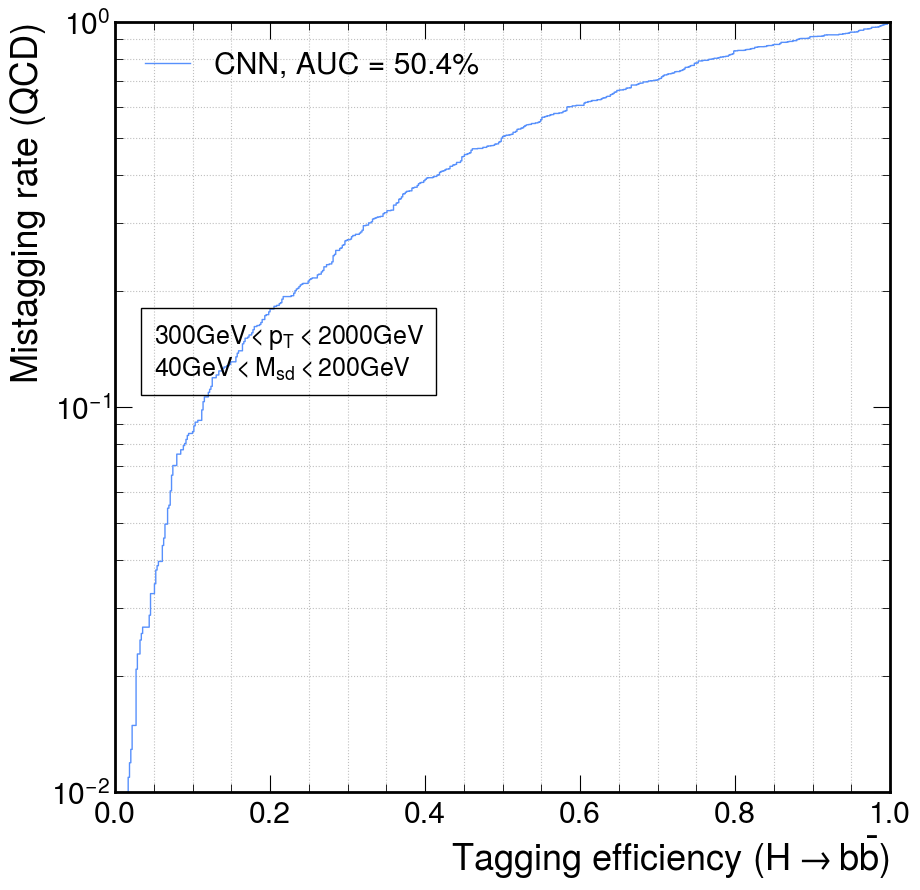

In [30]:
# Plot ROC curves
plt.figure()
plt.plot(tpr_cnn, fpr_cnn, lw = 1, label = "CNN, AUC = {:.1f}%".format(auc_cnn))
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

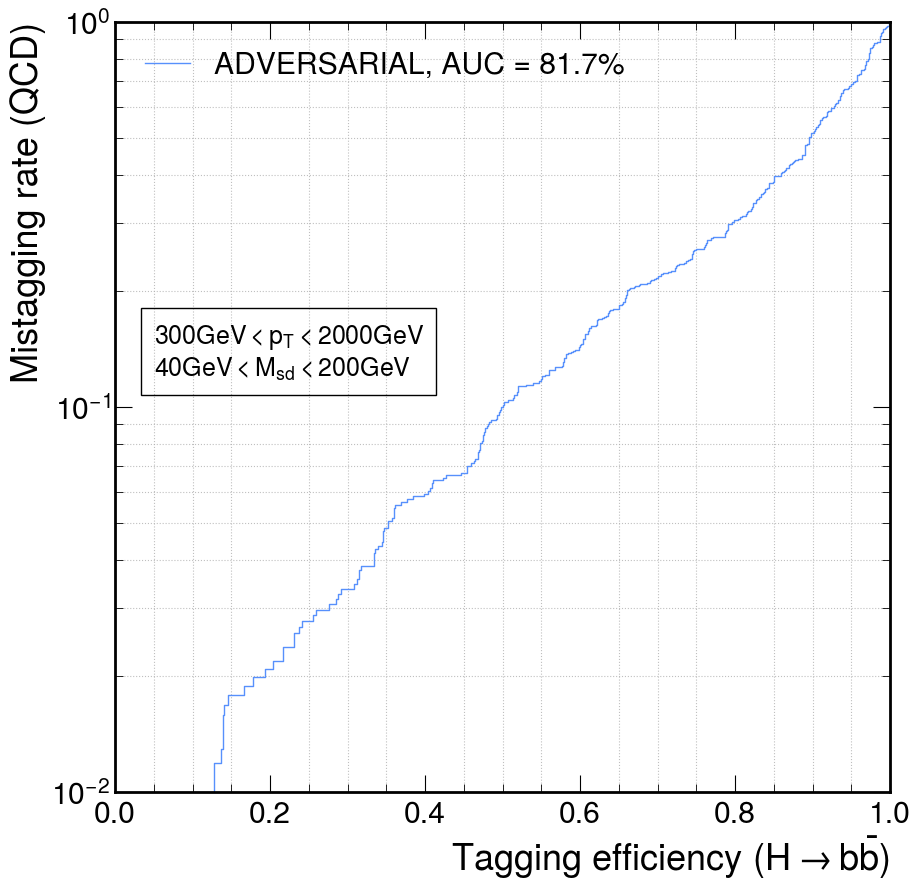

In [31]:
# Plot ROC curves
plt.figure()
plt.plot(tpr_adversarial, fpr_adversarial, lw = 1, label = "ADVERSARIAL, AUC = {:.1f}%".format(auc_adversarial))
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

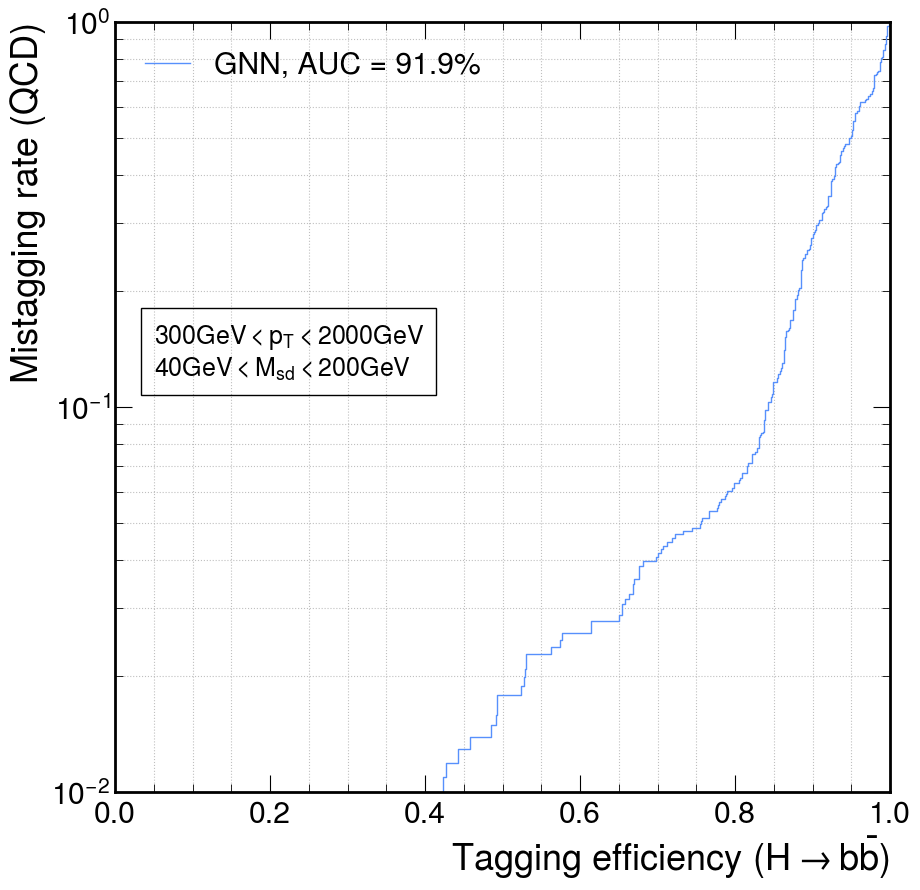

In [32]:
# Plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw = 1, label = "GNN, AUC = {:.1f}%".format(auc_gnn))
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$')
plt.ylabel(r'Mistagging rate (QCD)')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.01, 1)
plt.grid(True, which = 'minor')
plt.legend(loc = 'upper left')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

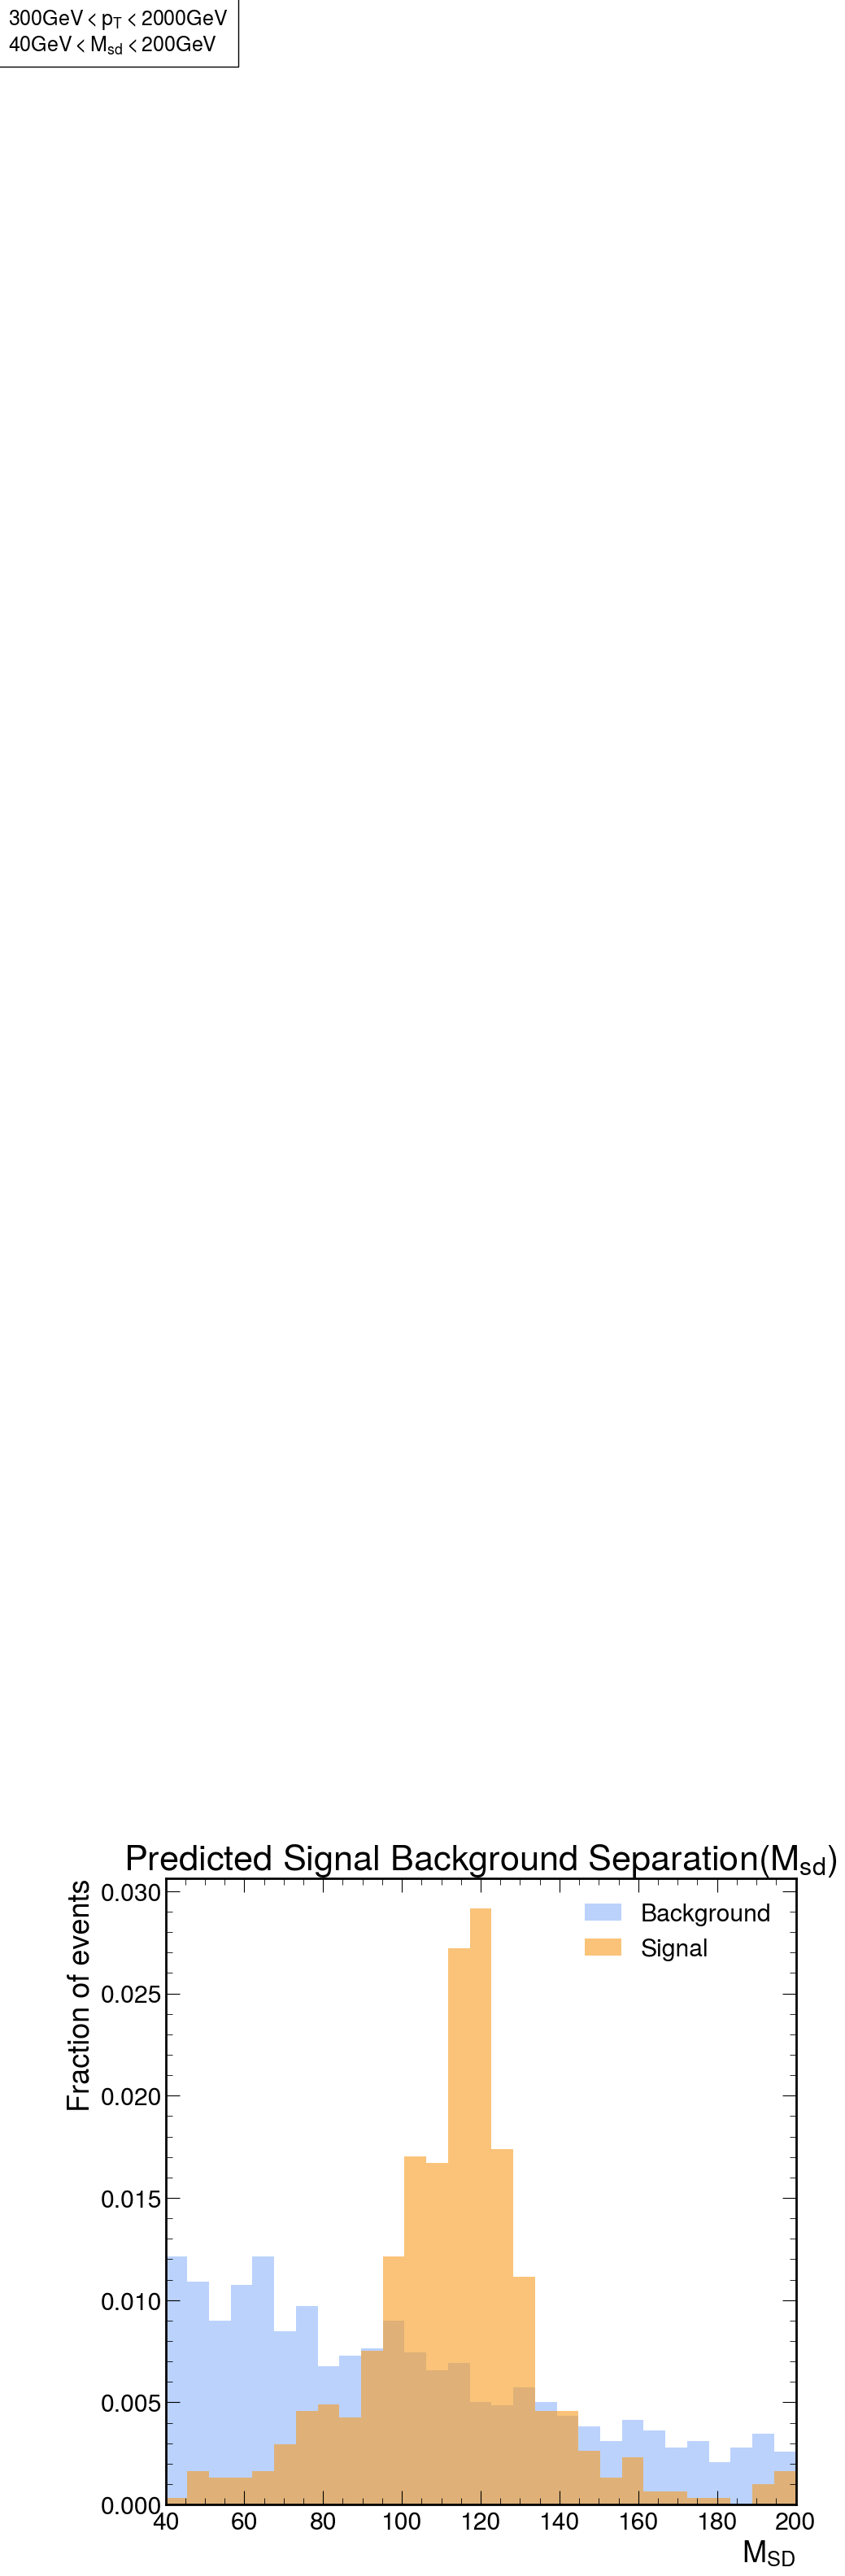

In [33]:
plt.figure()
plt.hist(spectator_array_bdt[:, 0][label_array_bdt_predict[:, 0] > 0.5 ], bins = np.linspace(40, 200, 30), density = True, label = 'Background', alpha = 0.4)
plt.hist(spectator_array_bdt[:, 0][label_array_bdt_predict[:, 1] > 0.5], bins = np.linspace(40, 200, 30), density = True, label = 'Signal', alpha = 0.6)
plt.xlabel(r'$M_{SD}$')
plt.ylabel('Fraction of events')
plt.legend()
plt.xlim(40, 200)
plt.title(r'Predicted Signal Background Separation($M_{sd}$)')

# Text inside a box
label_text = r'$300GeV < p_T < 2000GeV$'+'\n'+r'$40GeV < M_{sd} < 200GeV$'
x_pos, y_pos = 0.05, 0.12

plt.text(
    x_pos, y_pos, label_text,
    fontsize=18,
    color='black',
    bbox=dict(
        facecolor='none',  # Background color of box
        edgecolor='black',    # Edge color of box
        boxstyle='square,pad=0.5'  # Box style
    )
)

plt.show()

Fit parameters (A, x0, gamma): [ 19.9017226  115.79339471  26.2646502 ]
Interpolated FWHM: 26.26498744988504


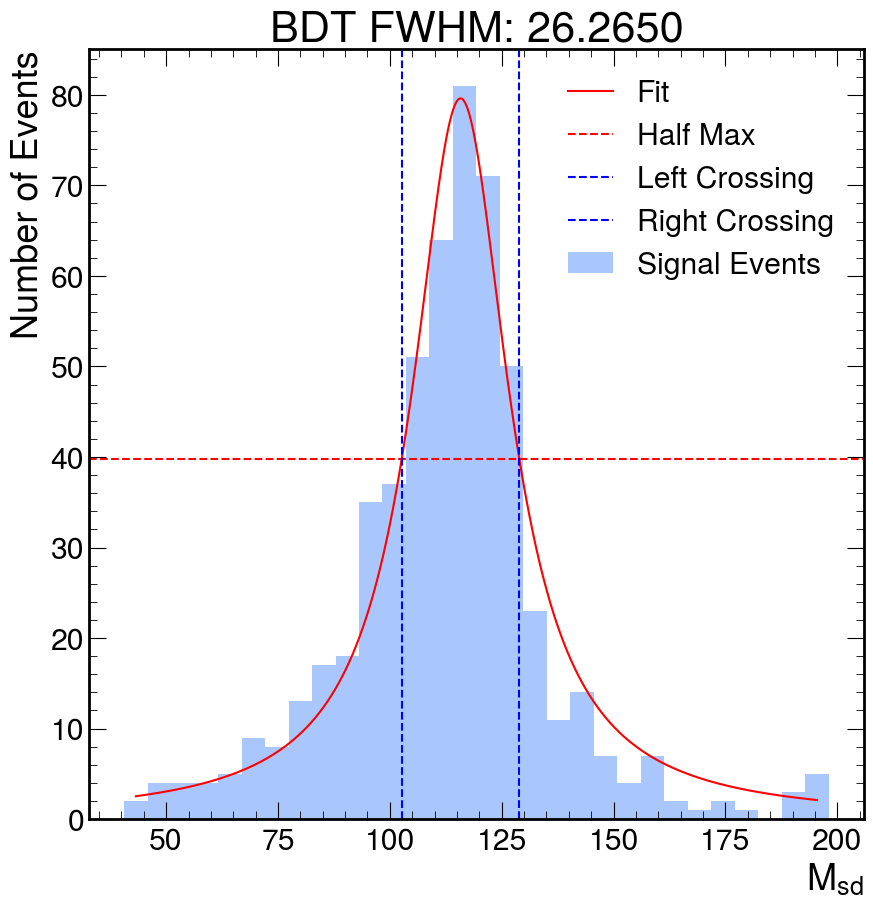

In [34]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
specs = [spectator_array_bdt, spectator_array_dnn, spectator_array_deepset, spectator_array_cnn, spectator_array_adversarial, spectator_array_gnn]
labels_p = [label_array_bdt_predict, label_array_dnn_predict, label_array_deepset_predict, label_array_cnn_predict, label_array_adversarial_predict, label_array_gnn_predict]
mod = ['BDT', 'DNN', 'Deepset', 'CNN', 'Adversarial', 'GNN']
i = 0
counts, edges = np.histogram(specs[i][:, 0][labels_p[i][:, 1] > 0.5], bins = 30)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Breit-Wigner (Lorentzian) function
def breit_wigner(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + (gamma/2)**2))

# Initial parameter guesses: amplitude, peak, width
p0 = [np.max(counts), bin_centers[np.argmax(counts)], 1.0]

# Fit
popt, pcov = curve_fit(breit_wigner, bin_centers, counts, p0=p0)
print("Fit parameters (A, x0, gamma):", popt)

# Find indices above half maximum
x_fine = np.linspace(bin_centers[0], bin_centers[-1], 1000)
y_fine = breit_wigner(x_fine, *popt)

y_fine = breit_wigner(x_fine, *popt)
# Compute half-maximum
half_max = np.max(y_fine) / 2

# Subtract half_max to find zero crossings
y_diff = y_fine - half_max

# Find approximate crossing points by checking sign changes
cross_indices = np.where(np.diff(np.sign(y_diff)))[0]
crossings = []
for idx in cross_indices:
    # x interval: [x_fine[idx], x_fine[idx+1]]
    # y interval: [y_diff[idx], y_diff[idx+1]]
    
    # Linear interpolation formula for zero crossing:
    x0 = x_fine[idx] - y_diff[idx] * (x_fine[idx+1] - x_fine[idx]) / (y_diff[idx+1] - y_diff[idx])
    crossings.append(x0)

x_left, x_right = crossings[0], crossings[-1]
fwhm = x_right - x_left

print(f"Interpolated FWHM: {fwhm}")

# Plot
plt.figure()
plt.bar(bin_centers, counts, width=edges[1]-edges[0], alpha=0.5, label='Signal Events')
plt.plot(x_fine, y_fine, 'r-', label='Fit')

plt.axhline(half_max, color='r', linestyle='--', label='Half Max')
plt.axvline(x_left, color='b', linestyle='--', label='Left Crossing')
plt.axvline(x_right, color='b', linestyle='--', label='Right Crossing')
plt.title(f"{mod[i]} FWHM: {fwhm:.4f}")
plt.legend()
plt.xlabel(r'$M_{sd}$')
plt.ylabel('Number of Events')

plt.show()



In [35]:
specs = [spectator_array_bdt, spectator_array_dnn, spectator_array_deepset, spectator_array_cnn, spectator_array_adversarial, spectator_array_gnn]
labels_p = [label_array_bdt_predict, label_array_dnn_predict, label_array_deepset_predict, label_array_cnn_predict, label_array_adversarial_predict, label_array_gnn_predict]
labels = [label_array_bdt, label_array_dnn, label_array_deepset, label_array_cnn, label_array_adversarial, label_array_gnn]
mod = ['BDT', 'DNN', 'Deepset', 'CNN', 'Adversarial', 'GNN']
for i in range(6):
    counts, edges = np.histogram(specs[i][:, 0][labels_p[i][:, 1] > 0.5], bins = 30)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    avg_count, avg_sq_count = (sum(counts*bin_centers))/sum(counts), (sum(counts*bin_centers**2))/sum(counts)
    std_1 = np.sqrt(avg_sq_count - avg_count**2)
    # Number of signal events falling within one standard deviation
    percent_sig_event_predict = np.sum(counts[(bin_centers >= (avg_count-std_1)) & (bin_centers <= (avg_count+std_1))])/np.sum(labels_p[i][:, 1] > 0.5)*100
    percent_sig_event = np.sum(counts[(bin_centers >= (avg_count-std_1)) & (bin_centers <= (avg_count+std_1))])/np.sum(labels[i][:, 1] > 0.5)*100
    print('-'*50)
    print(f"Mean value of the jet mass predicted by {mod[i]} is {avg_count:.4f}GeV with 1 standard deviation {std_1:.4f}GeV")
    print(f"Percentage(wrt predicted number) of signal event fall under 1 standard deviation by {mod[i]} is {percent_sig_event_predict}")
    print(f"Percentage(wrt true number) of signal event fall under 1 standard deviation by {mod[i]} is {percent_sig_event}")
    print('-'*50)
    print(len(specs[i]))

--------------------------------------------------
Mean value of the jet mass predicted by BDT is 112.8486GeV with 1 standard deviation 23.0754GeV
Percentage(wrt predicted number) of signal event fall under 1 standard deviation by BDT is 77.75768535262206
Percentage(wrt true number) of signal event fall under 1 standard deviation by BDT is 72.88135593220339
--------------------------------------------------
1599
--------------------------------------------------
Mean value of the jet mass predicted by DNN is 113.9983GeV with 1 standard deviation 23.1125GeV
Percentage(wrt predicted number) of signal event fall under 1 standard deviation by DNN is 76.25
Percentage(wrt true number) of signal event fall under 1 standard deviation by DNN is 62.03389830508475
--------------------------------------------------
1599
--------------------------------------------------
Mean value of the jet mass predicted by Deepset is 104.0815GeV with 1 standard deviation 28.7732GeV
Percentage(wrt predicted numb

<Figure size 1000x1000 with 0 Axes>

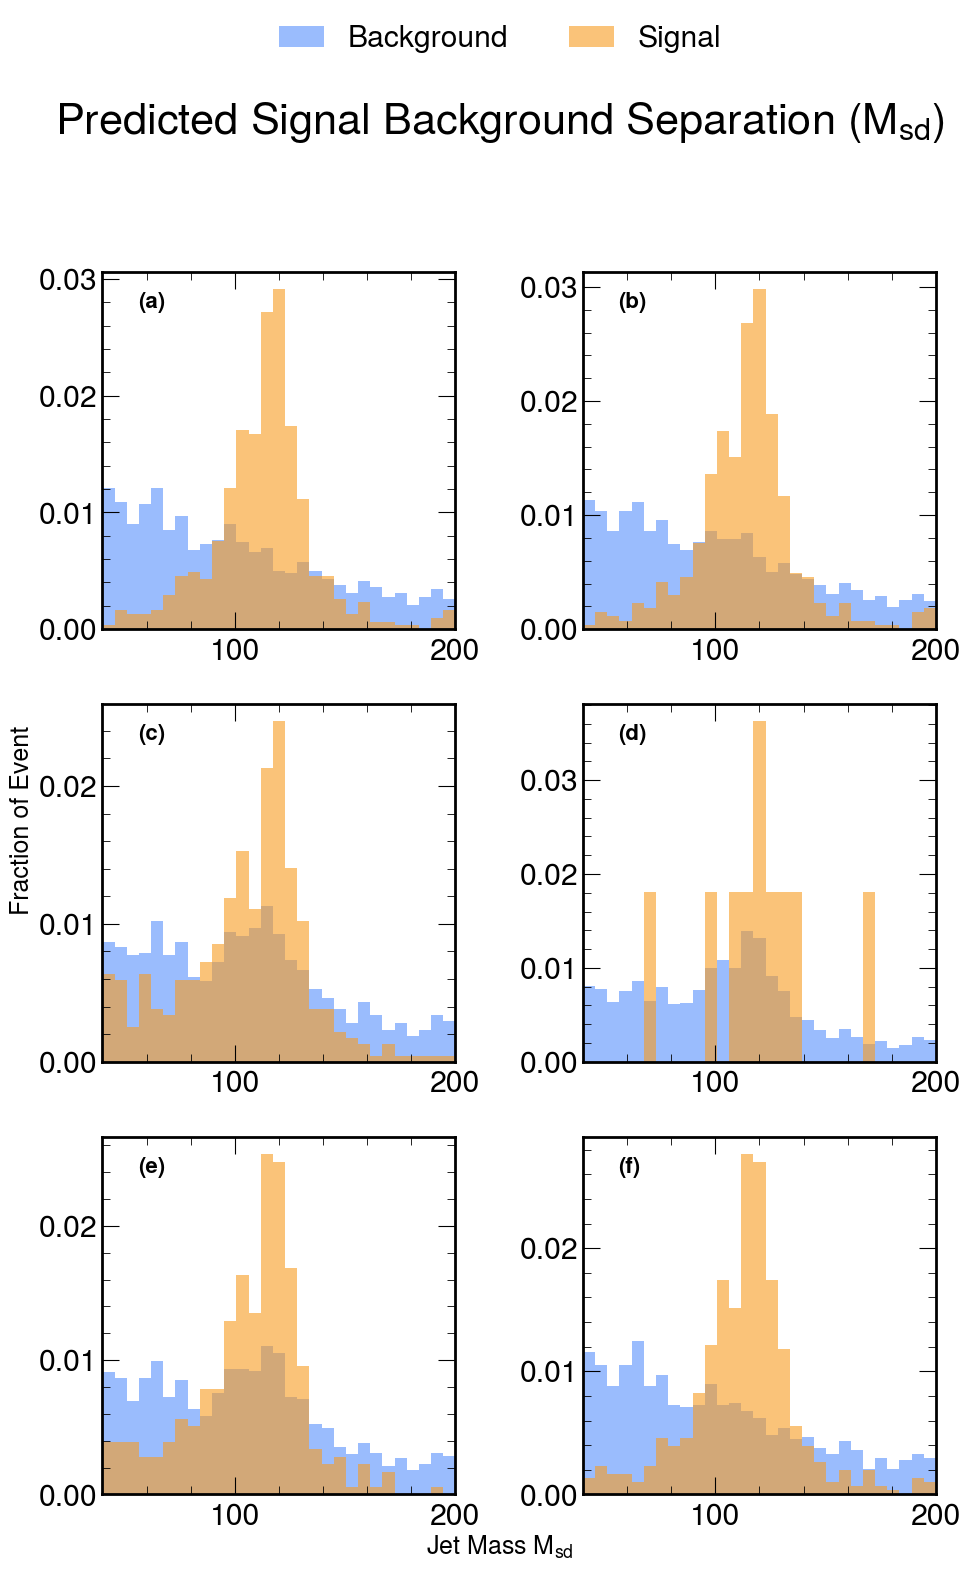

In [36]:
plt.figure()
fig, ax = plt.subplots(3, 2, figsize = (10, 15))
ax[0][0].hist(spectator_array_bdt[:, 0][label_array_bdt_predict[:, 0] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[0][0].hist(spectator_array_bdt[:, 0][label_array_bdt_predict[:, 1] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Signal")
ax[0][1].hist(spectator_array_dnn[:, 0][label_array_dnn_predict[:, 0] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[0][1].hist(spectator_array_dnn[:, 0][label_array_dnn_predict[:, 1] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[1][0].hist(spectator_array_deepset[:, 0][label_array_deepset_predict[:, 0] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[1][0].hist(spectator_array_deepset[:, 0][label_array_deepset_predict[:, 1] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[1][1].hist(spectator_array_cnn[:, 0][label_array_cnn_predict[:, 0] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[1][1].hist(spectator_array_cnn[:, 0][label_array_cnn_predict[:, 1] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[2][0].hist(spectator_array_adversarial[:, 0][label_array_adversarial_predict[:, 0] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[2][0].hist(spectator_array_adversarial[:, 0][label_array_adversarial_predict[:, 1] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[2][1].hist(spectator_array_gnn[:, 0][label_array_gnn_predict[:, 0] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
ax[2][1].hist(spectator_array_gnn[:, 0][label_array_gnn_predict[:, 1] > 0.5 ], density = True, bins = np.linspace(40, 200, 30), alpha = 0.6, label = "Background")
plt.suptitle(r"Predicted Signal Background Separation $(M_{sd})$")
for i in range(3):
    for j in range(2):
        ax[i][j].set_xlim(40, 200)
        
        ax[i][j].text(
            0.1, 0.9,   # Position (x, y) in **axes coordinates** (0–1)
            f'({chr(97 + i*2 + j)})',  # e.g., (a), (b), (c), (d), ...
            transform=ax[i][j].transAxes,  # Use axes coordinates
            fontsize=16,
            fontweight='bold',
            color='black'
        )

# Remove per-axes legends
# Use a single figure-level legend
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=2, frameon=False)

# Example: add common x and y labels
fig.text(0.5, 0.01, r'Jet Mass $M_{sd}$', ha='center', fontsize=18)
fig.text(0.01, 0.5, 'Fraction of Event', va='center', rotation='vertical', fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for suptitle and legend


plt.show()

# Confusion matrix

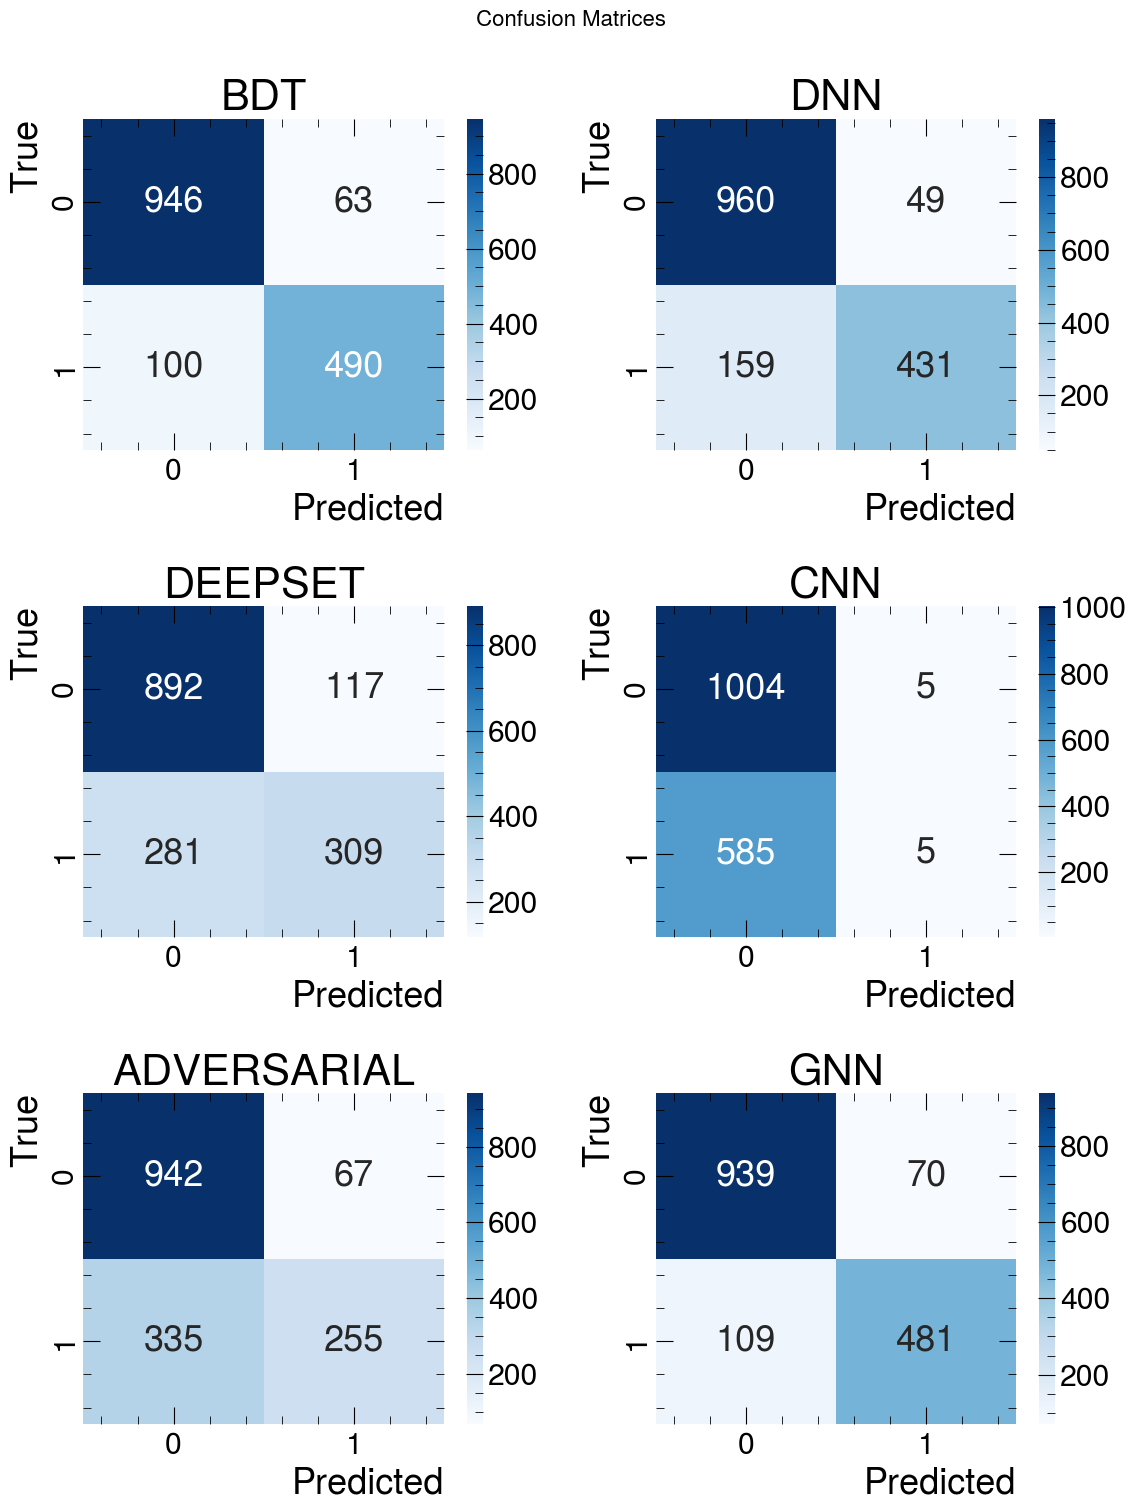

In [39]:
# import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Sample labels
label_array_bdt_t = label_array_bdt.T[1]
label_array_bdt_predict_p = label_array_bdt_predict.T[1].copy()
label_array_bdt_predict_p[label_array_bdt_predict_p > 0.5] = 1
label_array_bdt_predict_p[label_array_bdt_predict_p < 0.5] = 0

label_array_dnn_t = label_array_dnn.T[1]
label_array_dnn_predict_p = label_array_dnn_predict.T[1].copy()
label_array_dnn_predict_p[label_array_dnn_predict_p > 0.5] = 1
label_array_dnn_predict_p[label_array_dnn_predict_p < 0.5] = 0

label_array_deepset_t = label_array_deepset.T[1]
label_array_deepset_predict_p = label_array_deepset_predict.T[1].copy()
label_array_deepset_predict_p[label_array_deepset_predict_p > 0.5] = 1
label_array_deepset_predict_p[label_array_deepset_predict_p < 0.5] = 0

label_array_cnn_t = label_array_cnn.T[1]
label_array_cnn_predict_p = label_array_cnn_predict.T[1].copy()
label_array_cnn_predict_p[label_array_cnn_predict_p > 0.5] = 1
label_array_cnn_predict_p[label_array_cnn_predict_p < 0.5] = 0

label_array_adversarial_t = label_array_adversarial.T[1]
label_array_adversarial_predict_p = label_array_adversarial_predict.T[1].copy()
label_array_adversarial_predict_p[label_array_adversarial_predict_p > 0.5] = 1
label_array_adversarial_predict_p[label_array_adversarial_predict_p < 0.5] = 0

label_array_gnn_t = label_array_gnn.T[1]
label_array_gnn_predict_p = label_array_gnn_predict.T[1].copy()
label_array_gnn_predict_p[label_array_gnn_predict_p > 0.5] = 1
label_array_gnn_predict_p[label_array_gnn_predict_p < 0.5] = 0

# Helper function to compute confusion matrix and plot it in an axis
def plot_confusion_matrix(ax, true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=[0, 1], yticklabels=[0, 1], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

# Prepare figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], label_array_bdt_t, label_array_bdt_predict_p, 'BDT')
plot_confusion_matrix(axes[0, 1], label_array_dnn_t, label_array_dnn_predict_p, 'DNN')
plot_confusion_matrix(axes[1, 0], label_array_deepset_t, label_array_deepset_predict_p, 'DEEPSET')
plot_confusion_matrix(axes[1, 1], label_array_cnn_t, label_array_cnn_predict_p, 'CNN')
plot_confusion_matrix(axes[2, 0], label_array_adversarial_t, label_array_adversarial_predict_p, 'ADVERSARIAL')
plot_confusion_matrix(axes[2, 1], label_array_gnn_t, label_array_gnn_predict_p, 'GNN')

# Adjust layout
plt.tight_layout()
plt.suptitle('Confusion Matrices', fontsize=16, y=1.02)  # Adjust y for proper title spacing

# Save to file (example, adjust filename as needed)

plt.show()

# Remaining stufs for boosted decision trees


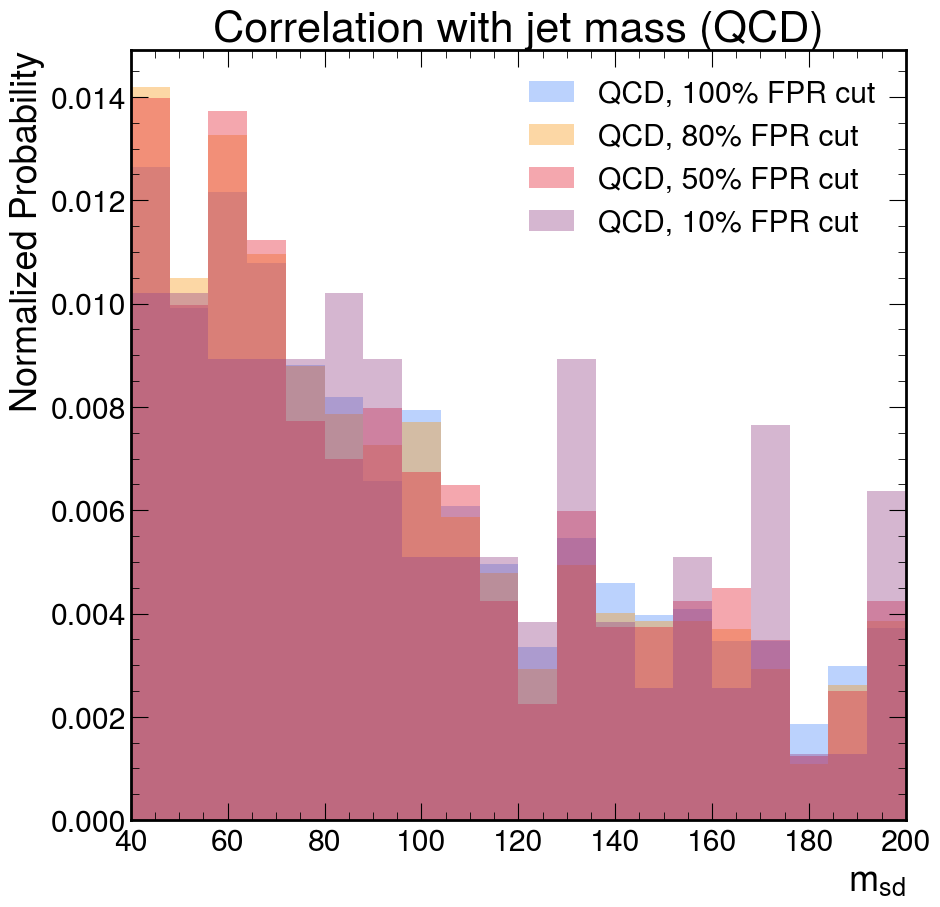

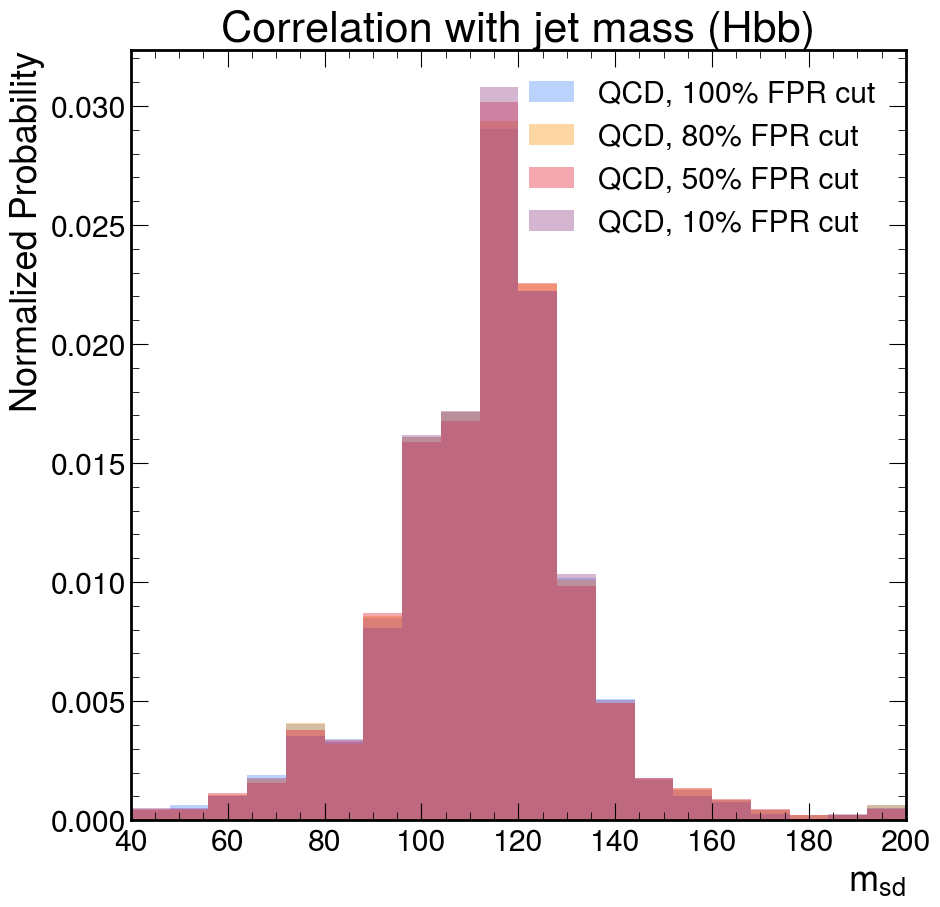

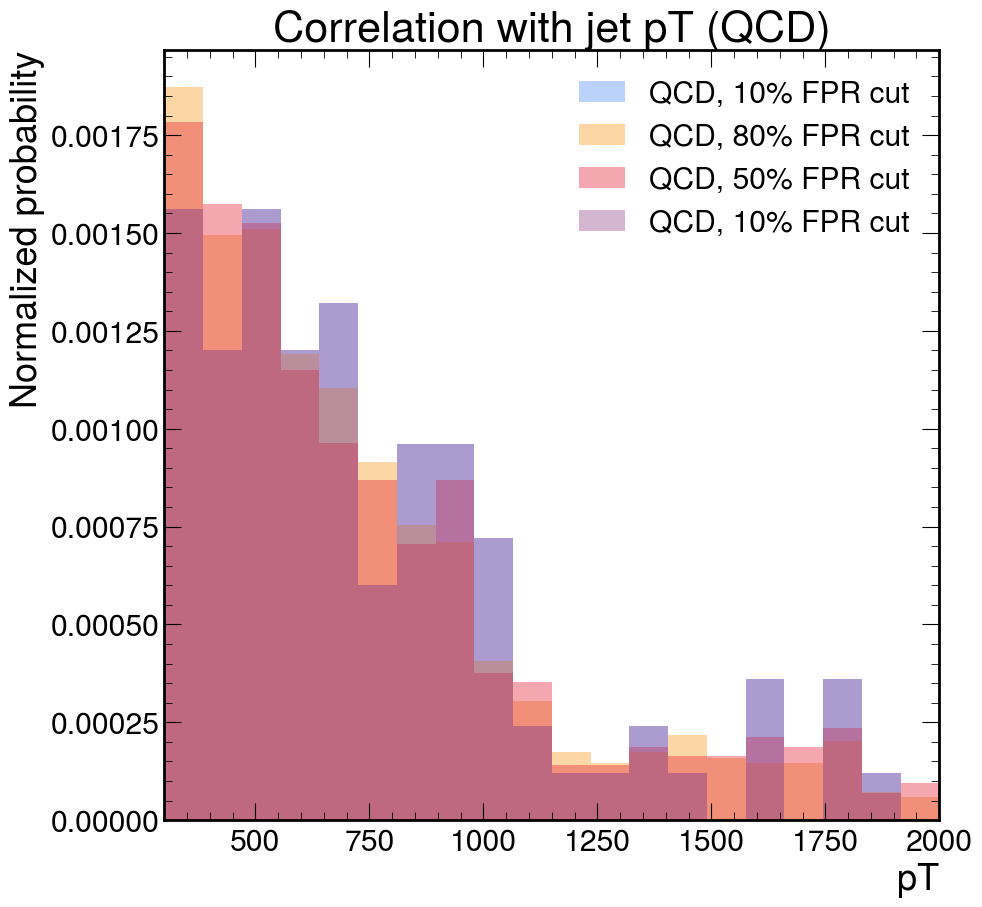

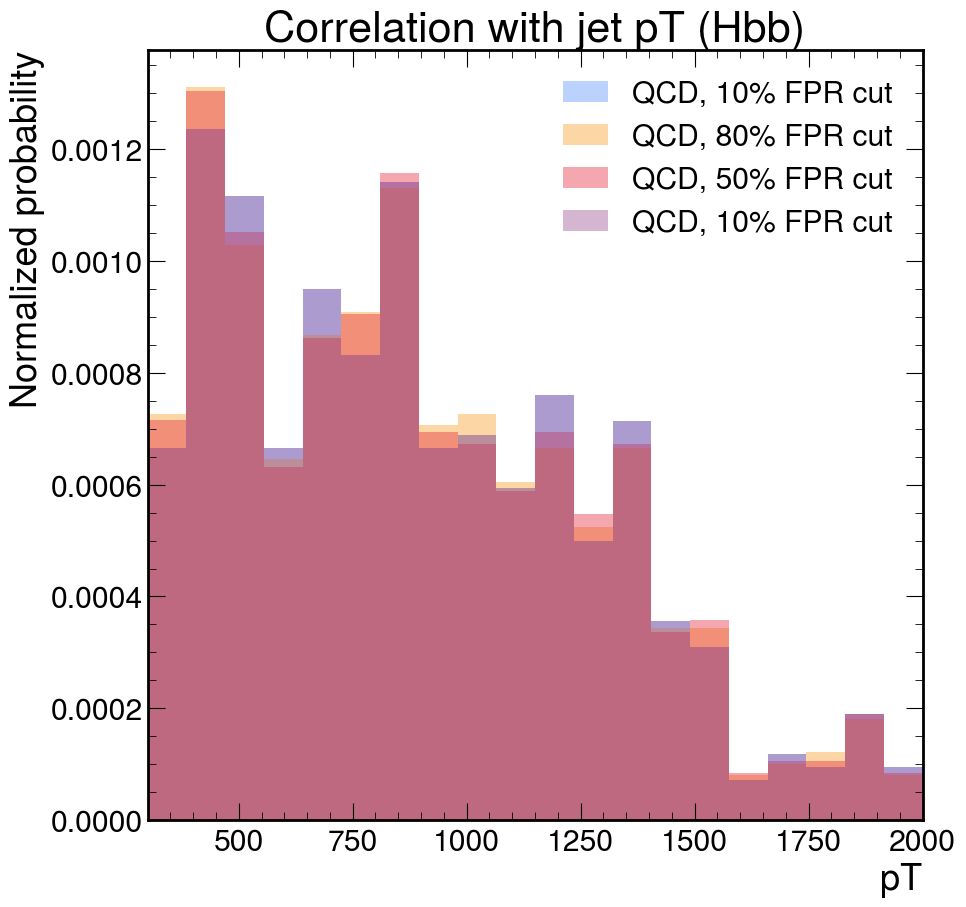

In [40]:
specs = [spectator_array_bdt, spectator_array_dnn, spectator_array_deepset, spectator_array_cnn, spectator_array_adversarial, spectator_array_gnn]
labels_p = [label_array_bdt_predict, label_array_dnn_predict, label_array_deepset_predict, label_array_cnn_predict, label_array_adversarial_predict, label_array_gnn_predict]
labels = [label_array_bdt, label_array_dnn, label_array_deepset, label_array_cnn, label_array_adversarial, label_array_gnn]
fprs = [fpr_bdt, fpr_dnn, fpr_deepset, fpr_cnn, fpr_adversarial, fpr_gnn]
thresholds = [threshold_bdt, threshold_dnn, threshold_deepset, threshold_cnn, threshold_adversarial, threshold_gnn]
mod = ['bdt', 'dnn', 'deepset', 'cnn', 'adversarial', 'gnn']
i = 5

# Note here that we put cut in the soft drop mass of the fat-jet at 40 and 200. So, it considered in between them.
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

# FPR cut in the QCD Background Events
plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fprs[i], wp)
    plt.hist(specs[i][:, 0], bins = np.linspace(40, 200, 21),
            weights= labels[i][:, 0]*(labels_p[i][:, 1] > thresholds[i][idx]),
            label = 'QCD, {}% FPR cut'.format(int(wp*100)),
            linestyle = '-',
            density = True,
            alpha = 0.4)
    plt.legend()


plt.xlabel(r'$m_{sd}$')
plt.ylabel('Normalized Probability')
plt.xlim(40, 200)
plt.title("Correlation with jet mass (QCD)")
plt.show()

plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fprs[i], wp)
    plt.hist(specs[i][:, 0], bins = np.linspace(40, 200, 21),
            weights= labels[i][:, 1]*(labels_p[i][:, 1] > thresholds[i][idx]),
            label = 'QCD, {}% FPR cut'.format(int(wp*100)),
            linestyle = '-',
            density = True,
            alpha = 0.4)
    plt.legend()


plt.xlabel(r'$m_{sd}$')
plt.ylabel('Normalized Probability')
plt.xlim(40, 200)
plt.title("Correlation with jet mass (Hbb)")
plt.show()

plt.figure()
for wp in [0.1, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fprs[i], wp)
    plt.hist(specs[i][:, 1],
            bins = np.linspace(300, 2000, 21),
            weights = labels[i][:, 0]*(labels_p[i][:, 1] > thresholds[i][idx]),
            label = 'QCD, {}% FPR cut'.format(int(wp*100)),
            density = True,
            alpha = 0.4)

plt.legend()
plt.xlabel('pT')
plt.ylabel('Normalized probability')
plt.xlim(300, 2000)
plt.title("Correlation with jet pT (QCD)")
plt.show()

plt.figure()
for wp in [0.1, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fprs[i], wp)
    plt.hist(specs[i][:, 1],
            bins = np.linspace(300, 2000, 21),
            weights = labels[i][:, 1]*(labels_p[i][:, 1] > thresholds[i][idx]),
            label = 'QCD, {}% FPR cut'.format(int(wp*100)),
            density = True,
            alpha = 0.4)

plt.legend()
plt.xlabel('pT')
plt.ylabel('Normalized probability')
plt.xlim(300, 2000)
plt.title("Correlation with jet pT (Hbb)")
plt.show()

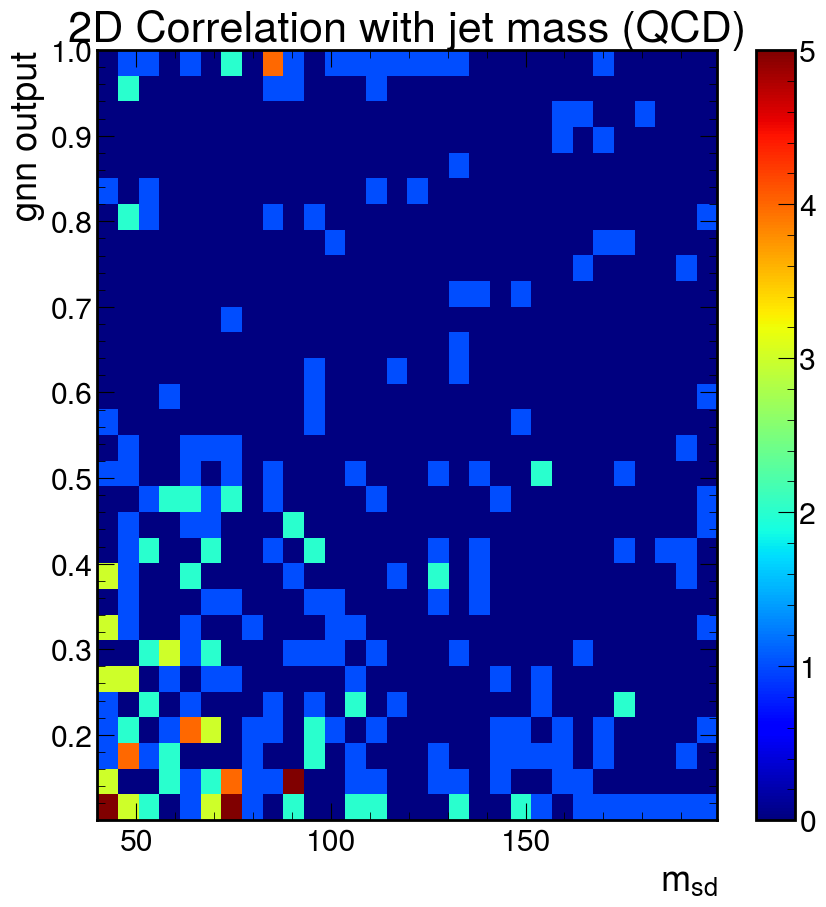

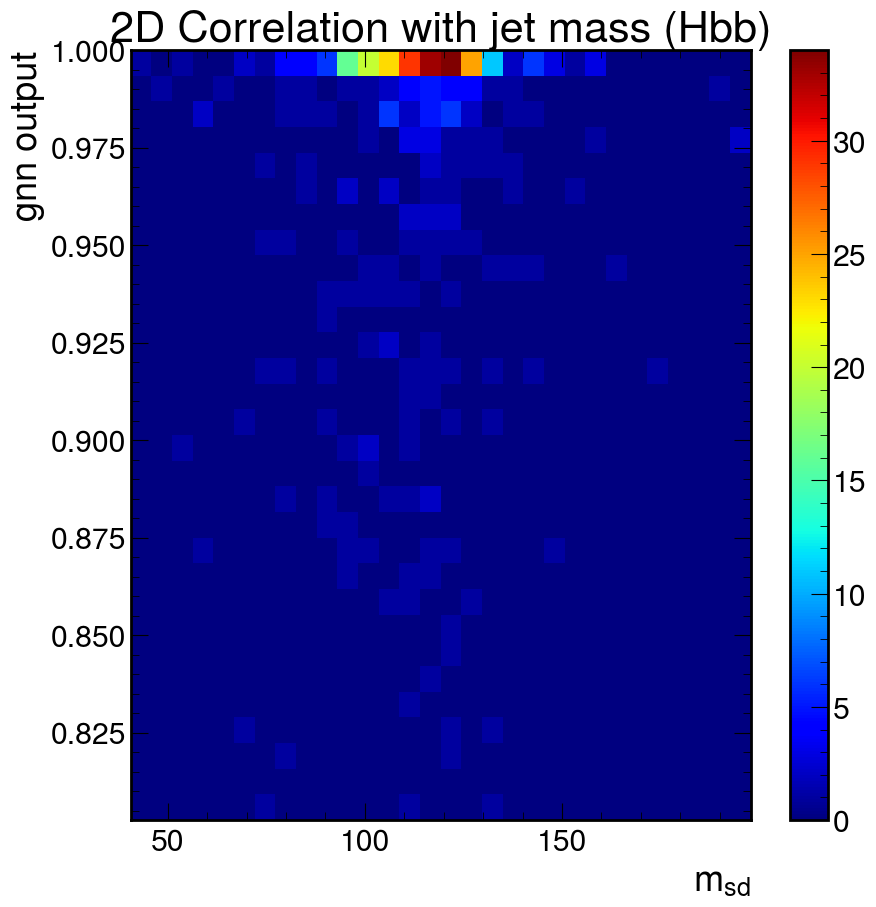

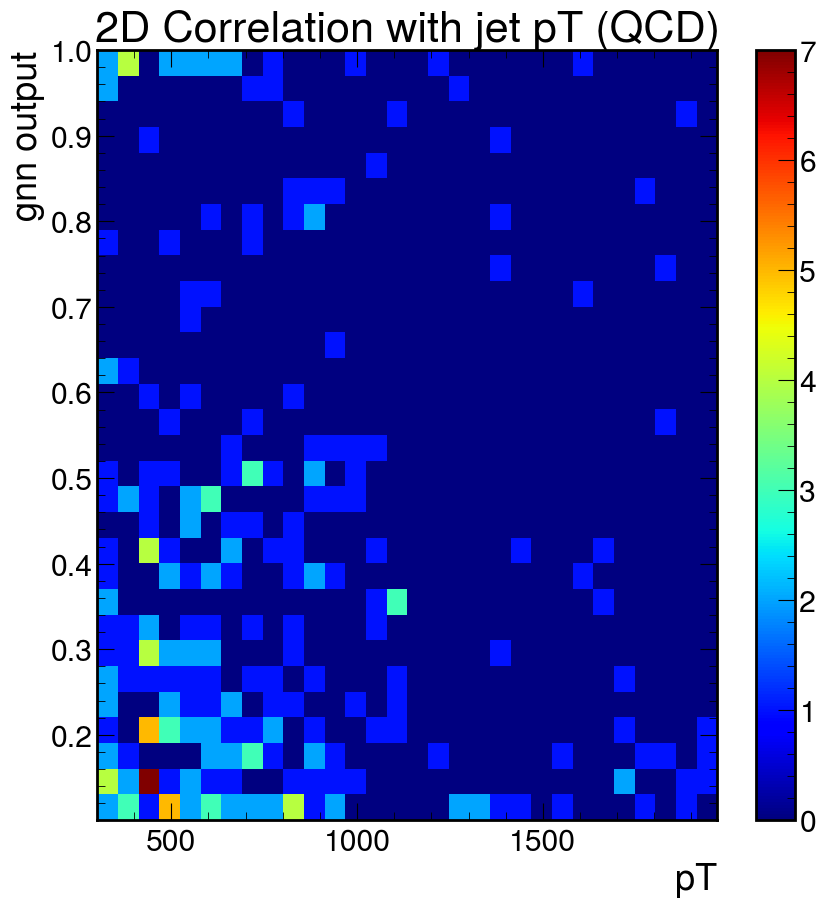

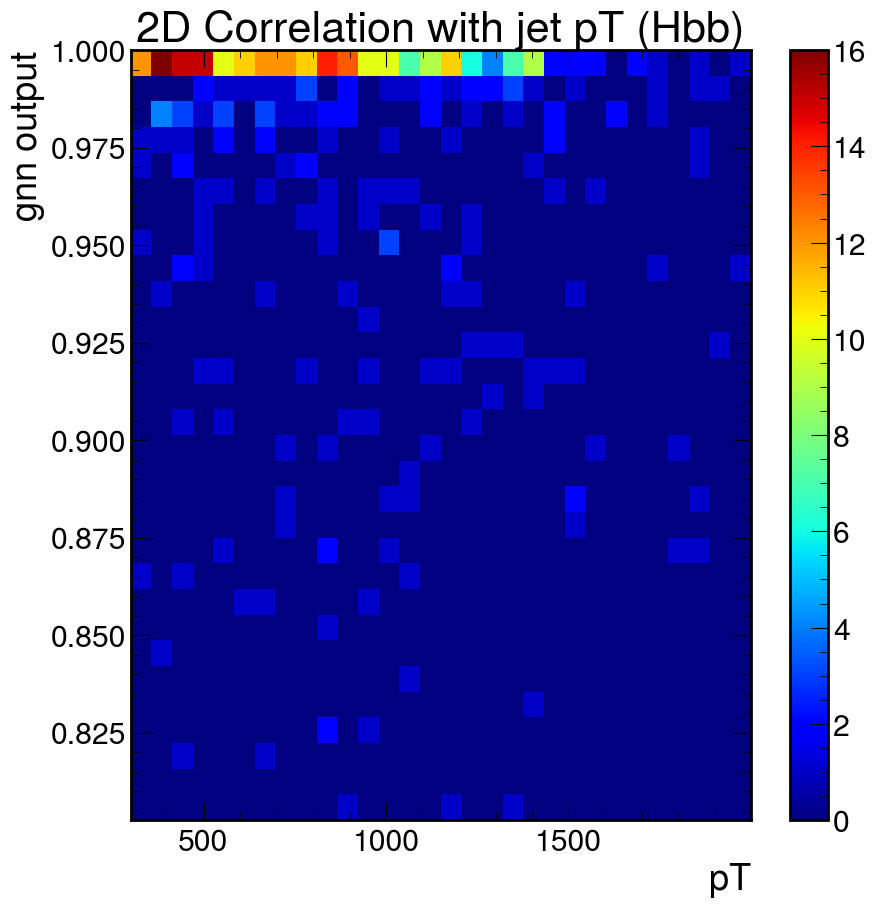

In [41]:
specs = [spectator_array_bdt, spectator_array_dnn, spectator_array_deepset, spectator_array_cnn, spectator_array_adversarial, spectator_array_gnn]
labels_p = [label_array_bdt_predict, label_array_dnn_predict, label_array_deepset_predict, label_array_cnn_predict, label_array_adversarial_predict, label_array_gnn_predict]
labels = [label_array_bdt, label_array_dnn, label_array_deepset, label_array_cnn, label_array_adversarial, label_array_gnn]
fprs = [fpr_bdt, fpr_dnn, fpr_deepset, fpr_cnn, fpr_adversarial, fpr_gnn]
thresholds = [threshold_bdt, threshold_dnn, threshold_deepset, threshold_cnn, threshold_adversarial, threshold_gnn]
mod = ['bdt', 'dnn', 'deepset', 'cnn', 'adversarial', 'gnn']
i = 5

# 2d Histograms
plt.figure()
plt.hist2d(specs[i][:, 0][(labels[i][:, 0] == 1) & (labels_p[i][:, 1] > 0.1)],
          labels_p[i][:, 1][(labels[i][:, 0] == 1) & (labels_p[i][:, 1] > 0.1)],
          bins = (30, 30),
          cmap = plt.cm.jet)

plt.colorbar()
plt.xlabel(r'$m_{sd}$')
plt.ylabel(f"{mod[i]} output")
plt.title("2D Correlation with jet mass (QCD)")
plt.show()

plt.figure()
plt.hist2d(specs[i][:, 0][(labels[i][:, 1] == 1) & (labels_p[i][:, 1] > 0.8)],
          labels_p[i][:, 1][(labels[i][:, 1] == 1) & (labels_p[i][:, 1] > 0.8)],
          bins = (30, 30),
          cmap = plt.cm.jet)

plt.colorbar()
plt.xlabel(r'$m_{sd}$')
plt.ylabel(f"{mod[i]} output")
plt.title("2D Correlation with jet mass (Hbb)")
plt.show()

plt.figure()
plt.hist2d(specs[i][:, 1][(labels[i][:, 0] == 1) & (labels_p[i][:, 1] > 0.1)],
          labels_p[i][:, 1][(labels[i][:, 0] == 1) & (labels_p[i][:, 1] > 0.1)],
          bins = (30, 30),
          cmap = plt.cm.jet)
plt.colorbar()
plt.xlabel('pT')
plt.ylabel(f"{mod[i]} output")
plt.title("2D Correlation with jet pT (QCD)")
plt.show()

plt.figure()
plt.hist2d(specs[i][:, 1][(labels[i][:, 1] == 1) & (labels_p[i][:, 1] > 0.8)],
          labels_p[i][:, 1][(labels[i][:, 1] == 1) & (labels_p[i][:, 1] > 0.8)],
          bins = (30, 30),
          cmap = plt.cm.jet)
plt.colorbar()
plt.xlabel('pT')
plt.ylabel(f"{mod[i]} output")
plt.title("2D Correlation with jet pT (Hbb)")
plt.show()

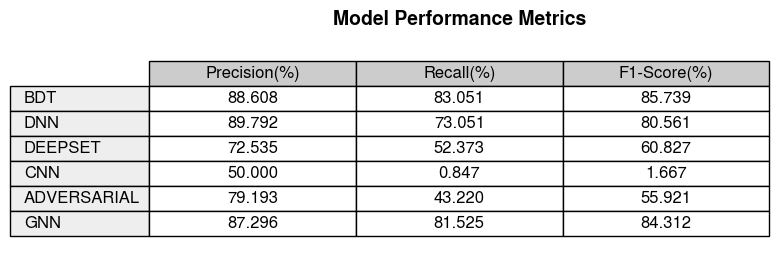

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_bdt = precision_score(label_array_bdt_t, label_array_bdt_predict_p)*100
recall_bdt = recall_score(label_array_bdt_t, label_array_bdt_predict_p)*100
f1_score_bdt = f1_score(label_array_bdt_t, label_array_bdt_predict_p)*100

precision_dnn = precision_score(label_array_dnn_t, label_array_dnn_predict_p)*100
recall_dnn = recall_score(label_array_dnn_t, label_array_dnn_predict_p)*100
f1_score_dnn = f1_score(label_array_dnn_t, label_array_dnn_predict_p)*100

precision_deepset = precision_score(label_array_deepset_t, label_array_deepset_predict_p)*100
recall_deepset = recall_score(label_array_deepset_t, label_array_deepset_predict_p)*100
f1_score_deepset = f1_score(label_array_deepset_t, label_array_deepset_predict_p)*100

precision_cnn = precision_score(label_array_cnn_t, label_array_cnn_predict_p)*100
recall_cnn = recall_score(label_array_cnn_t, label_array_cnn_predict_p)*100
f1_score_cnn = f1_score(label_array_cnn_t, label_array_cnn_predict_p)*100

precision_adversarial = precision_score(label_array_adversarial_t, label_array_adversarial_predict_p)*100
recall_adversarial = recall_score(label_array_adversarial_t, label_array_adversarial_predict_p)*100
f1_score_adversarial = f1_score(label_array_adversarial_t, label_array_adversarial_predict_p)*100

precision_gnn = precision_score(label_array_gnn_t, label_array_gnn_predict_p)*100
recall_gnn = recall_score(label_array_gnn_t, label_array_gnn_predict_p)*100
f1_score_gnn = f1_score(label_array_gnn_t, label_array_gnn_predict_p)*100

# Data
models = ['BDT', 'DNN', 'DEEPSET', 'CNN', 'ADVERSARIAL', 'GNN']
precisions = [precision_bdt, precision_dnn, precision_deepset, precision_cnn, precision_adversarial, precision_gnn]
recalls = [recall_bdt, recall_dnn, recall_deepset, recall_cnn, recall_adversarial, recall_gnn]
f1_scores = [f1_score_bdt, f1_score_dnn, f1_score_deepset, f1_score_cnn, f1_score_adversarial, f1_score_gnn]

# Table data
cell_text = []
for row in zip(precisions, recalls, f1_scores):
    cell_text.append([f"{x:.3f}" for x in row])

# Plotting
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

# Table
table = ax.table(
    cellText=cell_text,
    rowLabels=models,
    colLabels=['Precision(%)', 'Recall(%)', 'F1-Score(%)'],
    loc='center',
    cellLoc='center',
    colColours=['#cccccc']*3,  # Column header color
    rowColours=['#eeeeee']*6,  # Row header color
)

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  # row_height, col_width

plt.title("Model Performance Metrics", fontweight="bold", fontsize=14)
plt.show()

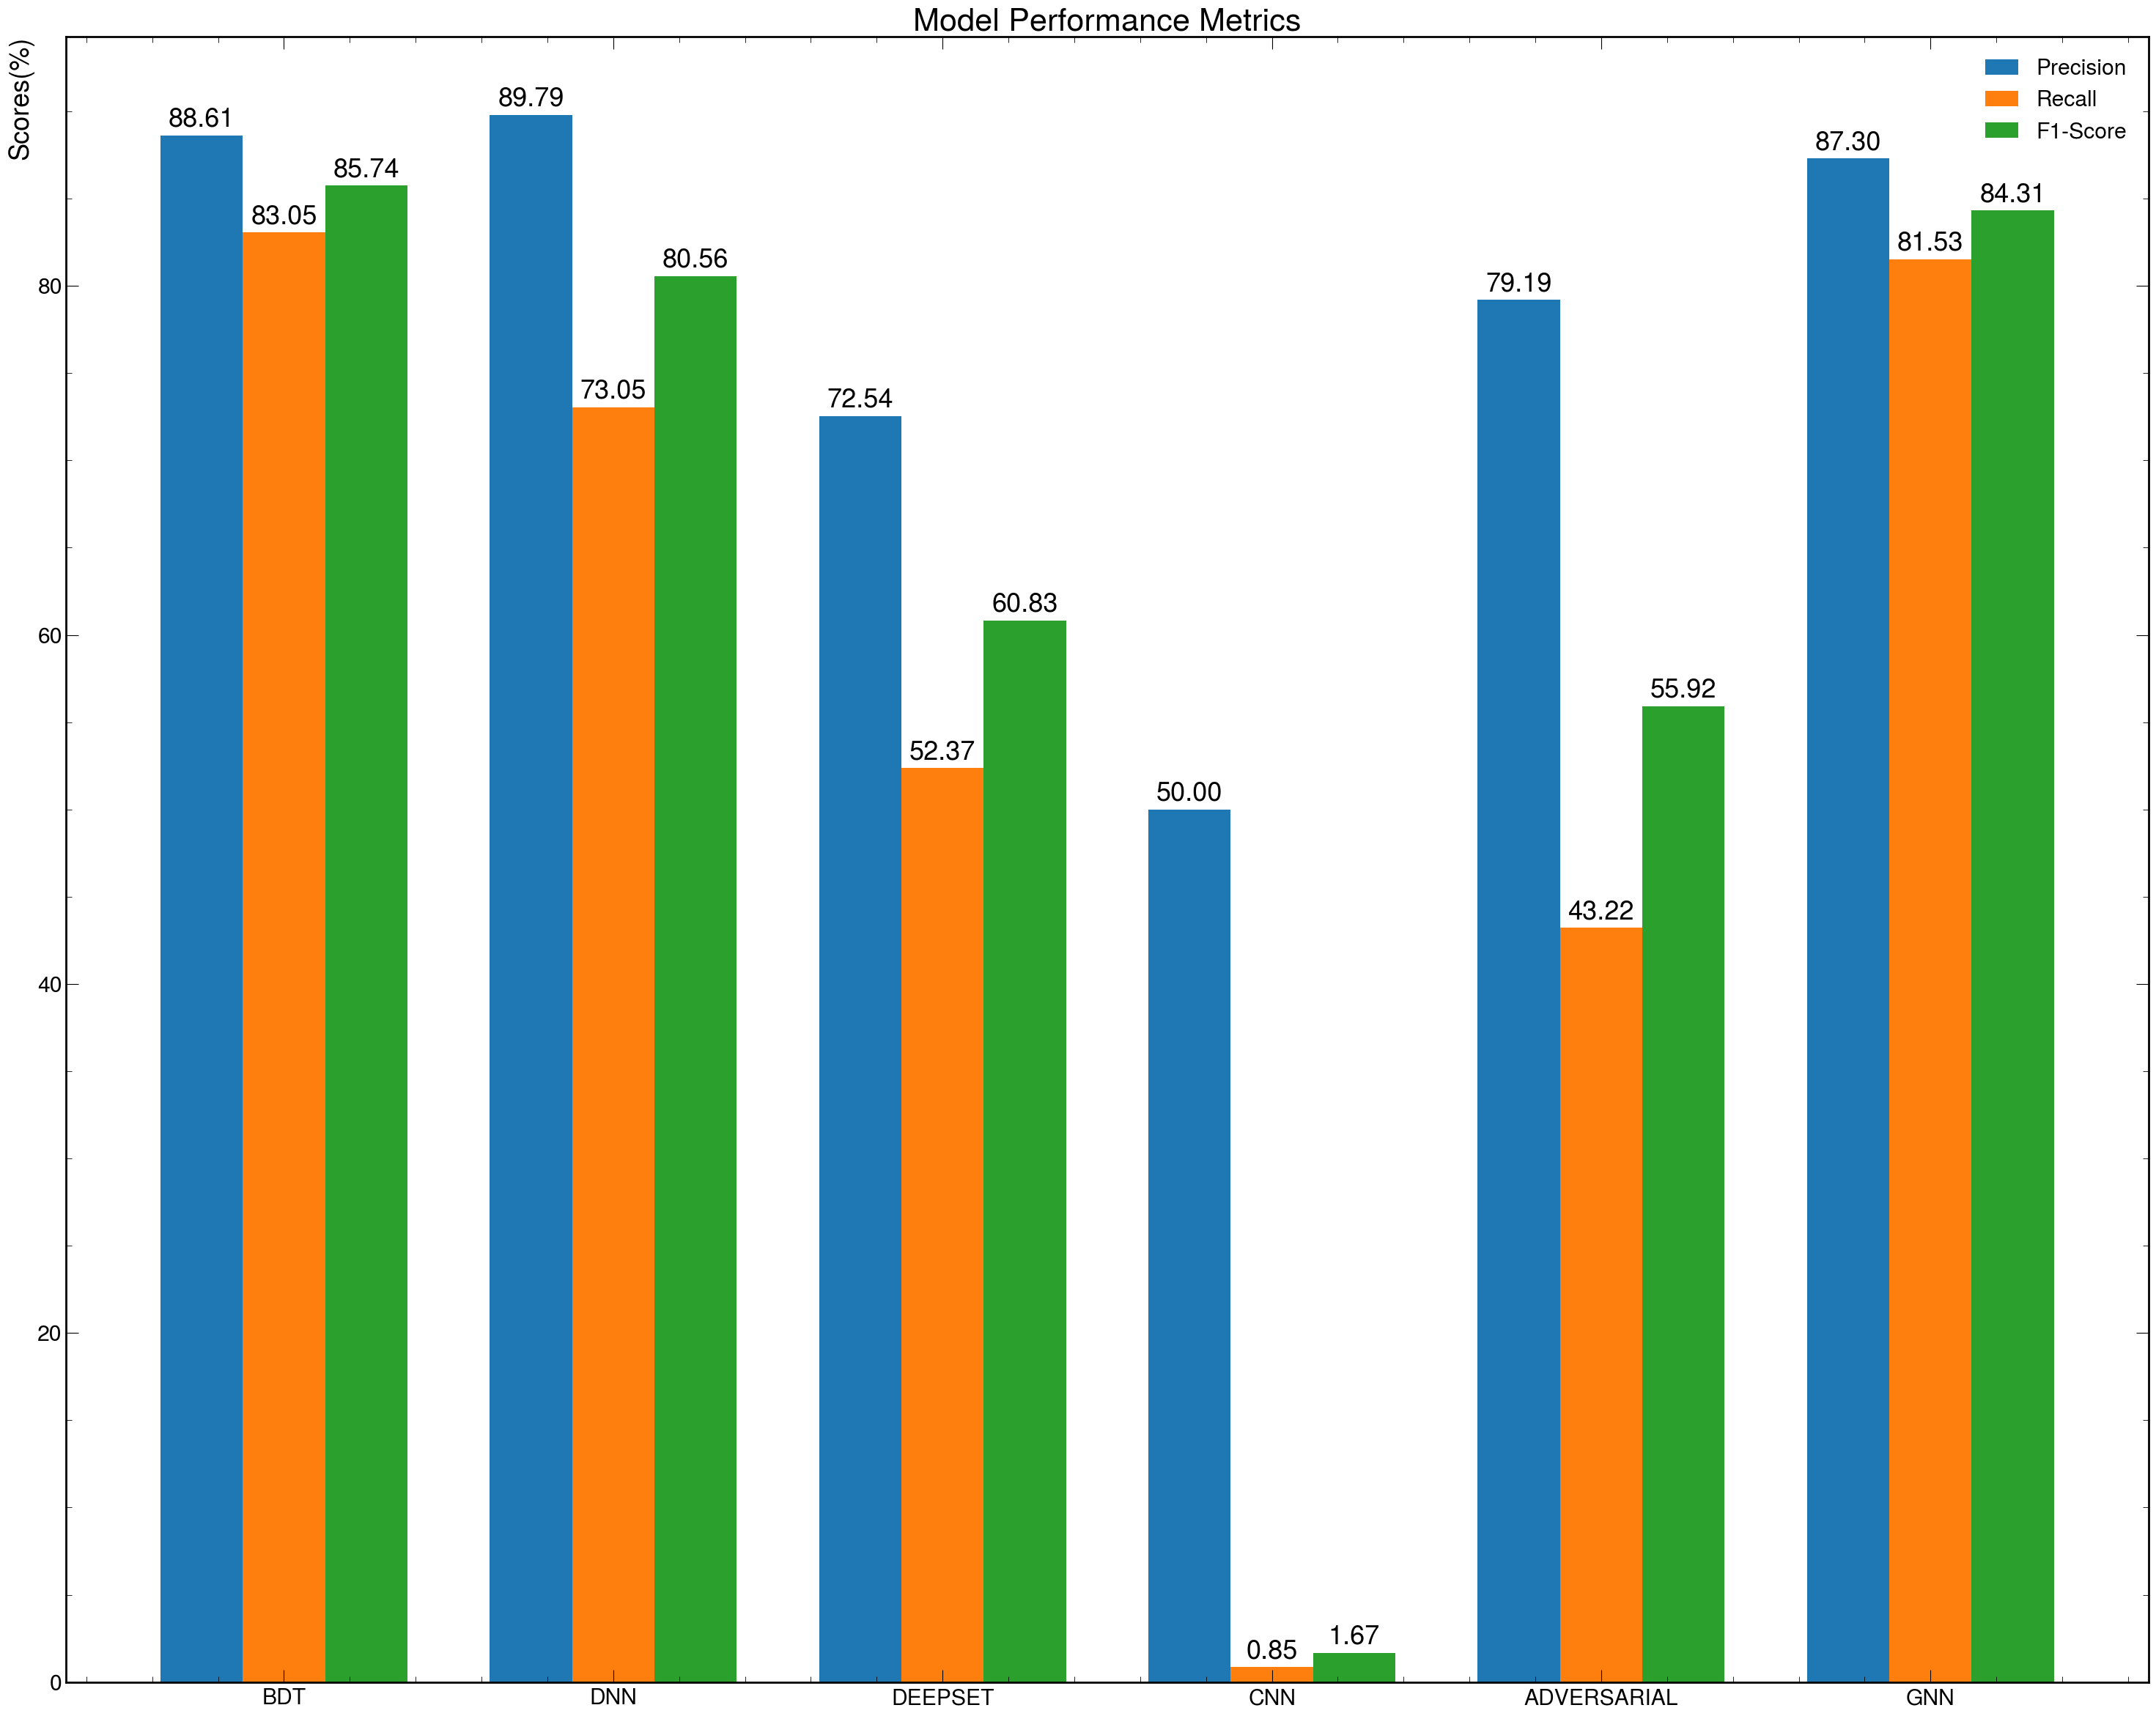

In [43]:
import numpy as np

x = np.arange(len(models))  # label locations
width = 0.25

fig, ax = plt.subplots(figsize=(30, 24))

rects1 = ax.bar(x - width, precisions, width, label='Precision', color='tab:blue')
rects2 = ax.bar(x, recalls, width, label='Recall', color='tab:orange')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='tab:green')

ax.set_ylabel('Scores(%)')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()
